# Notes
In this instance, we demonstrate the `self-supervised` pretraining process using the TCGA cohort dataset. Upon completion of the pretraining phase, our model will be saved as a feature extractor. This entails exporting the pretrained model, ensuring its readiness for downstream applications. For the downstream tasks, we will utilize this pretrained model to extract latent features from the specific dataset intended for these tasks. Utilizing these extracted features, we will then construct a straightforward linear probing method to facilitate prediction

In [1]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-responder/')
from responder.utils import plot_embed_with_label
from responder import PreTrainer, FineTuner

In [2]:
#Quadro RTX 8000

In [3]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [4]:
data_path = '../../data/'
df_tpm = pd.read_pickle(os.path.join(data_path, 'TCGA', 'TPM.TCGA.TABLE'))
df_label = pd.read_pickle(os.path.join(data_path, 'TCGA', 'PATIENT.PROCESSED.TCGA.TABLE'))
df_gene = pd.read_pickle(os.path.join(data_path,'TCGA',  'GENE.TABLE'))
df_cancer = df_label[['cancer_type']]
n_samples = len(df_label)

In [5]:
task_name = 'TCGA_tmb' #self-supervised learning (ssl), no joint task

# generate a decoder (placeholder) task, will not train this task
df_task = onehot(df_label['tmb'])
task_type = 'c'

test_idx = df_cancer.groupby('cancer_type').apply(lambda x:x.sample(frac=0.1, 
                                                                    random_state=123).index.tolist()).tolist()
test_idx = list(chain(*test_idx))
train_idx = df_cancer[~df_cancer.index.isin(test_idx)].index

df_task_train = df_task.loc[train_idx]
df_tpm_train = df_tpm.loc[train_idx]

df_task_test = df_task.loc[test_idx]
df_tpm_test = df_tpm.loc[test_idx]

print(df_tpm_train.shape, len(df_tpm_test))

(9166, 1005) 1018


In [6]:
# pth='/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/1005'
# df_new = pd.read_pickle(os.path.join(pth, 'RESPONSE.ALL.V12345.TABLE'))
# df_task2 = onehot(df_new.response)
# df_task2.columns = df_task.columns
# df_tpm2 = df_new[df_new.columns[:-1]]

# df_tpm_train = df_tpm_train._append(df_tpm2)._append(df_tpm2)
# df_task_train = df_task_train._append(df_task2)._append(df_task2)
# print(df_tpm_train.shape, len(df_tpm_test))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: senwanxiang. Use `wandb login --relogin` to force relogin


Epoch: 1/500 - Train Loss: 0.8347 - Test Loss: 0.8121
Epoch: 2/500 - Train Loss: 0.7879 - Test Loss: 0.7704
Epoch: 3/500 - Train Loss: 0.7539 - Test Loss: 0.7327
Epoch: 4/500 - Train Loss: 0.7104 - Test Loss: 0.6896
Epoch: 5/500 - Train Loss: 0.6801 - Test Loss: 0.6800
Epoch: 6/500 - Train Loss: 0.6600 - Test Loss: 0.6657
Epoch: 7/500 - Train Loss: 0.6474 - Test Loss: 0.6492
Epoch: 8/500 - Train Loss: 0.6339 - Test Loss: 0.6369
Epoch: 9/500 - Train Loss: 0.6235 - Test Loss: 0.6391
Epoch: 10/500 - Train Loss: 0.6174 - Test Loss: 0.6368
Epoch: 11/500 - Train Loss: 0.6098 - Test Loss: 0.6100
Epoch: 12/500 - Train Loss: 0.5992 - Test Loss: 0.6122
Epoch: 13/500 - Train Loss: 0.5925 - Test Loss: 0.5968
Epoch: 14/500 - Train Loss: 0.5908 - Test Loss: 0.5934
Epoch: 15/500 - Train Loss: 0.5866 - Test Loss: 0.6161
Epoch: 16/500 - Train Loss: 0.5779 - Test Loss: 0.5898
Epoch: 17/500 - Train Loss: 0.5765 - Test Loss: 0.5832
Epoch: 18/500 - Train Loss: 0.5738 - Test Loss: 0.5844
Epoch: 19/500 - Tra

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


pretrain_TCGA_tmb_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pretrain_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pretrain_ssl_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pretrain_test_TCGA_tmb_loss,█▆▅▄▄▃▂▃▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▂▁▃▁▁▁▁▂▁▁▂▂▁▂
pretrain_test_loss,█▆▄▄▃▃▂▃▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▂▁▂
pretrain_test_ssl_loss,█▆▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pretrain_TCGA_tmb_loss,0.52786
pretrain_loss,0.51027
pretrain_ssl_loss,0.1762
pretrain_test_TCGA_tmb_loss,0.60129
pretrain_test_loss,0.58043


Saving the model to ./results/Pretrain_TCGA_tmb_20240116_220014/pretrainer.pt


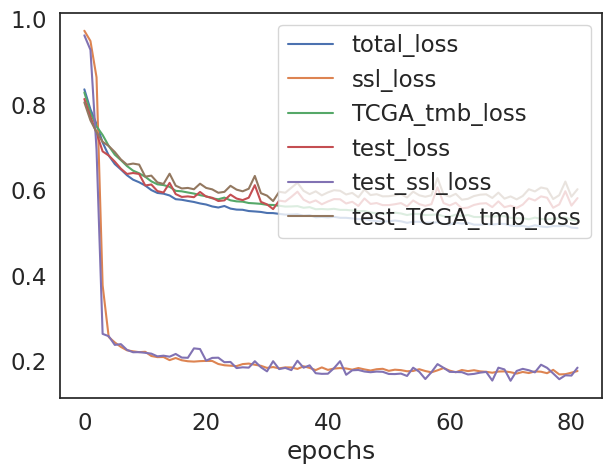

In [7]:
pretrainer = PreTrainer(
                        device='cuda',
                        encoder='transformer',
                        encoder_dropout = 0.0,
                        batch_size = 128,
                        epochs = 500, 
                        patience = 50,
                        lr = 1e-4, 
                        weight_decay = 1e-6,
                        K = 1, 
                        task_loss_weight = 0.95,
                        triplet_metric = 'cosine',
                        triplet_margin = 1,
                        with_wandb=True,
                        work_dir='./results')


pretrainer.train(df_tpm_train, 
                 df_task_train, 
                 task_name, 
                 task_type, 
                 df_tpm_test, 
                 df_task_test, 
                 aug_method = 'mask',
                 mask_a_prob = 0.1,
                 mask_p_prob = 0.1,
                 mask_n_prob = 0.1,                 
                )

pretrainer.close()

In [8]:
pretrainer.close()

Saving the model to ./results/Pretrain_TCGA_tmb_20240116_220014/pretrainer.pt


100%|##########| 36/36 [00:02<00:00, 15.05it/s]
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.8, n_epochs=50, n_neighbors=5, random_state=123, spread=1, verbose=1)
Tue Jan 16 22:50:43 2024 Construct fuzzy simplicial set
Tue Jan 16 22:50:43 2024 Finding Nearest Neighbors
Tue Jan 16 22:50:43 2024 Building RP forest with 10 trees
Tue Jan 16 22:50:46 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Tue Jan 16 22:50:57 2024 Finished Nearest Neighbor Search
Tue Jan 16 22:50:59 2024 Construct embedding


Epochs completed:   0%|            0/50 [00:00]

	completed  0  /  50 epochs
	completed  5  /  50 epochs
	completed  10  /  50 epochs
	completed  15  /  50 epochs
	completed  20  /  50 epochs
	completed  25  /  50 epochs
	completed  30  /  50 epochs
	completed  35  /  50 epochs
	completed  40  /  50 epochs
	completed  45  /  50 epochs
Tue Jan 16 22:51:01 2024 Finished embedding


[<Figure size 500x500 with 1 Axes>, <Figure size 500x500 with 1 Axes>]

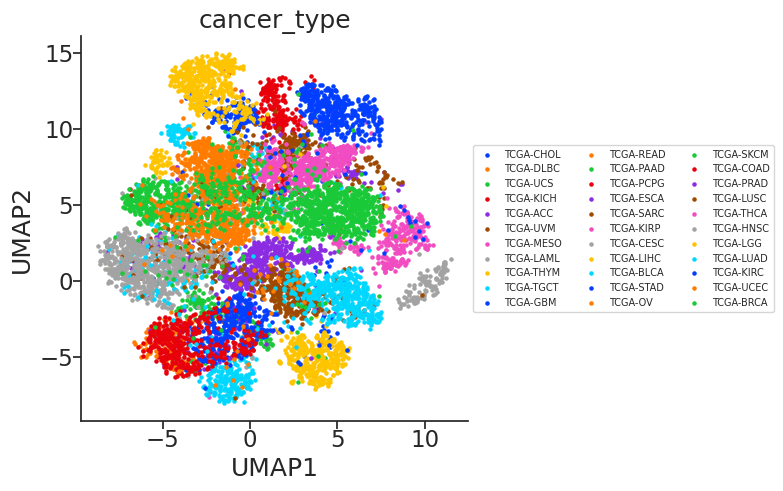

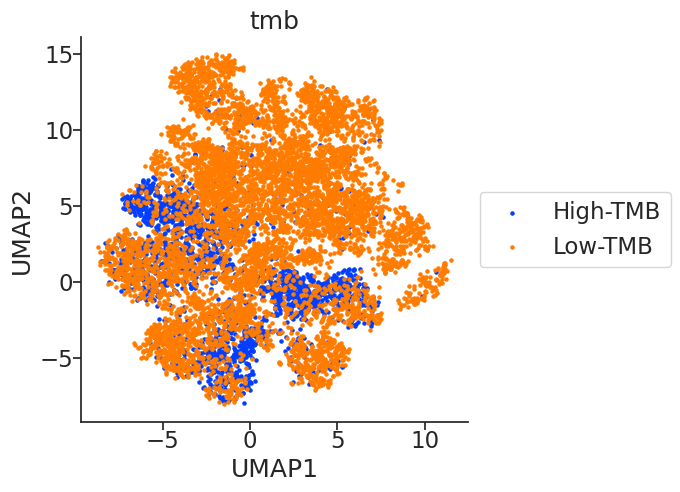

In [9]:
df_label_plot = df_label[['cancer_type', 'tmb']]
label_type = ['c', 'c']
df_tpm_train_emb, _ = pretrainer.predict(df_tpm_train, batch_size = 256)
dfp = df_tpm_train_emb.join(df_label_plot)
plot_embed_with_label(dfp, df_label_plot.columns, label_type, 
                      s=5, figsize=(5,5), min_dist = 0.8, 
                      metric = 'correlation', n_epochs=50)

100%|##########| 2/2 [00:00<00:00,  4.97it/s]
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.5, n_neighbors=5, random_state=123, spread=1, verbose=1)
Tue Jan 16 22:51:03 2024 Construct fuzzy simplicial set
Tue Jan 16 22:51:03 2024 Finding Nearest Neighbors
Tue Jan 16 22:51:05 2024 Finished Nearest Neighbor Search
Tue Jan 16 22:51:05 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jan 16 22:51:06 2024 Finished embedding


[<Figure size 500x500 with 1 Axes>, <Figure size 500x500 with 1 Axes>]

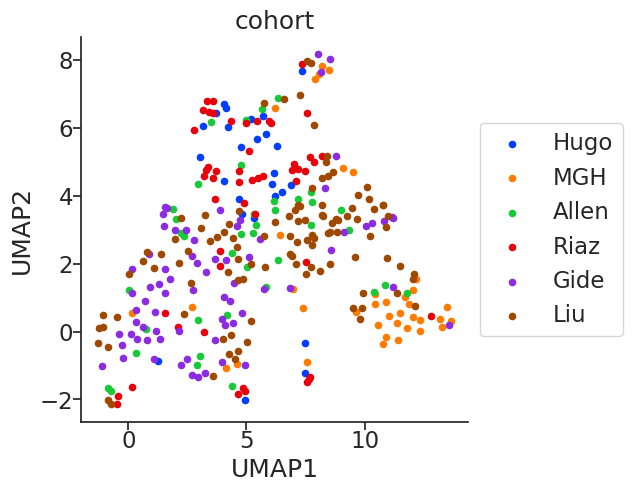

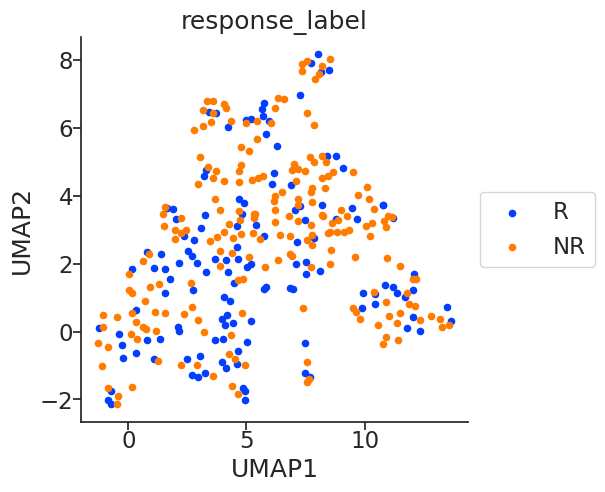

In [10]:
from responder.utils import plot_embed_with_label, score
itrp_meta = pd.read_pickle(os.path.join(data_path, 'SKCM','PATIENT.ITRP.TABLE'))
itrp_df_tpm = pd.read_pickle(os.path.join(data_path, 'SKCM','TPM.ITRP.TABLE'))
itrp_df_label = itrp_meta[['cohort', 'response_label']]
label_type = ['c', 'c']
itrp_df_tpm_emb, _ = pretrainer.predict(itrp_df_tpm, batch_size = 256)
dfp = itrp_df_tpm_emb.join(itrp_df_label)
plot_embed_with_label(dfp, itrp_df_label.columns, label_type, s=20, figsize=(5,5),)# min_dist = 0.8, metric = 'correlation', n_epochs=100